In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import Cityscapes
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
label_map = {
    0 : ['unlabeled', 255, 'void'], 
    1 : ['ego vehicle', 255, 'void'],
    2 : ['rectification border', 255, 'void'],
    3 : ['out of roi', 255, 'void'],
    4 : ['static', 255, 'void'],
    5 : ['dynamic', 255, 'void'],
    6 : ['ground', 255, 'void'],
    7 : ['road', 0, 'flat'],
    8 : ['sidewalk', 1, 'flat'],
    9 : ['parking', 255, 'flat'],
    10 : ['rail track', 255, 'flat'],
    11 : ['building', 2, 'construction'],
    12 : ['wall', 3, 'construction'],
    13 : ['fence', 4, 'construction'],
    14 : ['guard rail', 255, 'construction'],
    15 : ['bridge', 255, 'construction'],
    16 : ['tunnel', 255, 'construction'],
    17 : ['pole', 5, 'object'],
    18 : ['polegroup', 255, 'object'],
    19 : ['traffic light', 6, 'object'],
    20 : ['traffic sign', 7, 'object'],
    21 : ['vegetation', 8, 'nature'],
    22 : ['terrain', 9, 'nature'],
    23 : ['sky', 10, 'sky'],
    24 : ['person', 11, 'human'],
    25 : ['rider', 12, 'human'],
    26 : ['car', 13, 'vehicle'],
    27 : ['truck', 14, 'vehicle'],
    28 : ['bus', 15, 'vehicle'],
    29 : ['caravan', 255, 'vehicle'],
    30 : ['trailer', 255, 'vehicle'],
    31 : ['train', 16, 'vehicle'],
    32 : ['motorcycle', 17, 'vehicle'],
    33 : ['bicycle', 18, 'vehicle'],
    34 : ['license plate', -1, 'vehicle']
}

In [3]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        encx = torch.zeros(x.shape, dtype=torch.long)
        for label in label_map:
            encx[x == label] = label_map[label][1] if label_map[label][1] != 255 else 19
        return F.one_hot(encx.squeeze(1), 20).permute(0, 3, 1, 2)[0].float()

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 512)),
        transforms.Tensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 512)),
        transforms.PILToTensor(), 
        MakeClass()
    ]
)

train_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "train", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform
)

valid_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "val", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform    
)

test_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "test", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 2975
#Validation Samples: 500
#Testing Samples: 1525
#Training Batch: 93
#Validation Batch: 16
#Testing Batch: 48


Total #Classes: 20
data shape: torch.Size([3, 256, 512])
mask shape: torch.Size([20, 256, 512])
Number classes: 20
Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 19])


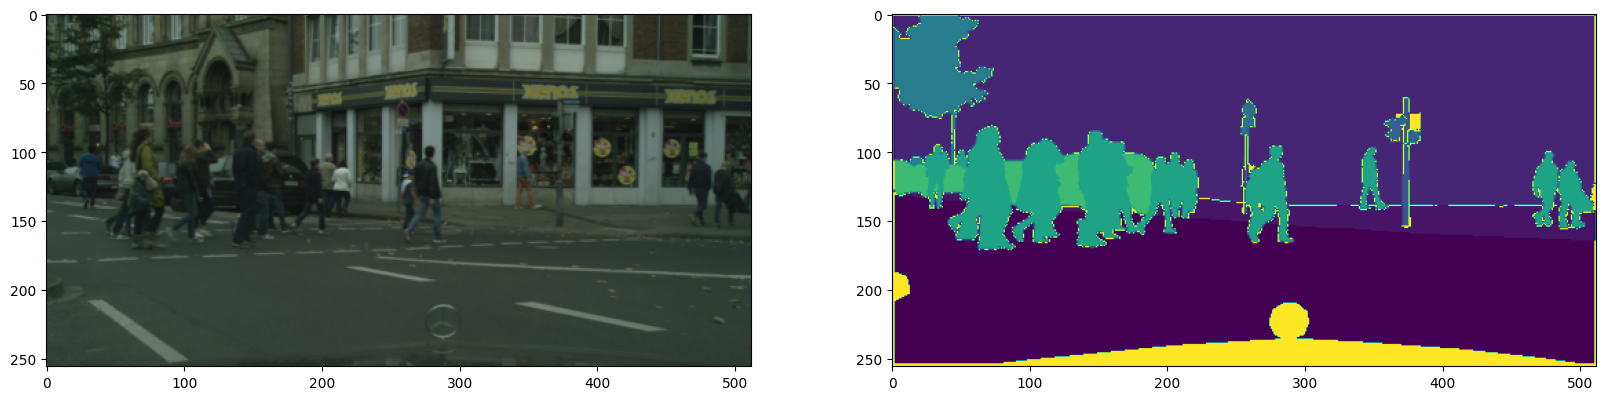

In [5]:
sample_data, sample_mask = train_ds[19]
total_num_class = 20

print(f"Total #Classes: {total_num_class}")
print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, total_num_class, True).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [13]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            valid_loss = loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = train_rec_loss + train_dice_loss

            va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:33<00:00,  2.06s/it]


Epoch: 0 - TrainLoss: 2.1227931809681717 - ValidLoss: 0.4362458388010661


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch: 1 - TrainLoss: 1.1742368725038344 - ValidLoss: 0.3339502811431885


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 2 - TrainLoss: 0.9826452937177432 - ValidLoss: 0.3121602733929952


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.21it/s]


Epoch: 3 - TrainLoss: 0.8987447106710045 - ValidLoss: 0.25658069054285687


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


Epoch: 4 - TrainLoss: 0.8450118264844341 - ValidLoss: 0.2533520460128784


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.22it/s]


Epoch: 5 - TrainLoss: 0.7990074696079377 - ValidLoss: 0.26560012499491376


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


Epoch: 6 - TrainLoss: 0.7649216299415916 - ValidLoss: 0.24464593331019083


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


Epoch: 7 - TrainLoss: 0.7338430644363485 - ValidLoss: 0.20925629138946533


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.22it/s]


Epoch: 8 - TrainLoss: 0.7083937756476864 - ValidLoss: 0.2417623003323873


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.08it/s]


Epoch: 9 - TrainLoss: 0.6892322878683766 - ValidLoss: 0.21746601661046347


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 10 - TrainLoss: 0.6718356320934911 - ValidLoss: 0.21603405475616455


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


Epoch: 11 - TrainLoss: 0.6511059377783088 - ValidLoss: 0.20299891630808511


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.18it/s]


Epoch: 12 - TrainLoss: 0.6362858728695941 - ValidLoss: 0.20794757207234701


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


Epoch: 13 - TrainLoss: 0.6162014058841172 - ValidLoss: 0.21758880217870077


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.16it/s]


Epoch: 14 - TrainLoss: 0.5987097197963346 - ValidLoss: 0.1917119820912679


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 15 - TrainLoss: 0.5832654071110551 - ValidLoss: 0.18705699841181436


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


Epoch: 16 - TrainLoss: 0.5812993466213185 - ValidLoss: 0.1953680912653605


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 17 - TrainLoss: 0.5686621028248982 - ValidLoss: 0.1715948979059855


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch: 18 - TrainLoss: 0.5554150733896481 - ValidLoss: 0.18005587657292685


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.16it/s]


Epoch: 19 - TrainLoss: 0.5355812746991393 - ValidLoss: 0.1712623437245687


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


Epoch: 20 - TrainLoss: 0.5304443586257196 - ValidLoss: 0.1917661428451538


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


Epoch: 21 - TrainLoss: 0.5147998672659679 - ValidLoss: 0.19139017661412558


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.27it/s]


Epoch: 22 - TrainLoss: 0.4991504408979929 - ValidLoss: 0.18056835730870566


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 23 - TrainLoss: 0.49324821977205174 - ValidLoss: 0.15740626056989035


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch: 24 - TrainLoss: 0.486781281809653 - ValidLoss: 0.14631600181261697


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.08it/s]


Epoch: 25 - TrainLoss: 0.4729161419535196 - ValidLoss: 0.17495844761530557


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.18it/s]


Epoch: 26 - TrainLoss: 0.4611495307055853 - ValidLoss: 0.16506659984588623


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


Epoch: 27 - TrainLoss: 0.4520732593792741 - ValidLoss: 0.14129742980003357


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.16it/s]


Epoch: 28 - TrainLoss: 0.4479480866462954 - ValidLoss: 0.14436769485473633


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch: 29 - TrainLoss: 0.4353219017546664 - ValidLoss: 0.1561297376950582


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 30 - TrainLoss: 0.413663379287207 - ValidLoss: 0.14209498961766562


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


Epoch: 31 - TrainLoss: 0.4163336423776483 - ValidLoss: 0.16571386655171713


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.18it/s]


Epoch: 32 - TrainLoss: 0.42103078512735265 - ValidLoss: 0.14757936199506125


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.18it/s]


Epoch: 33 - TrainLoss: 0.3958242772727884 - ValidLoss: 0.12769820292790732


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 34 - TrainLoss: 0.38280586529803534 - ValidLoss: 0.12757693727811178


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.22it/s]


Epoch: 35 - TrainLoss: 0.3706276855802023 - ValidLoss: 0.1178360382715861


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.15it/s]


Epoch: 36 - TrainLoss: 0.3679238628315669 - ValidLoss: 0.1225365400314331


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


Epoch: 37 - TrainLoss: 0.368575156055471 - ValidLoss: 0.1412375569343567


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 38 - TrainLoss: 0.3772860759048052 - ValidLoss: 0.1322477658589681


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 39 - TrainLoss: 0.3529496670410197 - ValidLoss: 0.11336960395177205


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.16it/s]


Epoch: 40 - TrainLoss: 0.36389899221799704 - ValidLoss: 0.12472281853357951


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.16it/s]


Epoch: 41 - TrainLoss: 0.34641733124691954 - ValidLoss: 0.11015814542770386


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.15it/s]


Epoch: 42 - TrainLoss: 0.3330683108939919 - ValidLoss: 0.111873726050059


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.15it/s]


Epoch: 43 - TrainLoss: 0.3273144335516037 - ValidLoss: 0.10919068257013957


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 44 - TrainLoss: 0.3222175548153539 - ValidLoss: 0.11185918251673381


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 45 - TrainLoss: 0.31612965849138075 - ValidLoss: 0.1076261301835378


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


Epoch: 46 - TrainLoss: 0.3117621717273548 - ValidLoss: 0.10973924398422241


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 47 - TrainLoss: 0.3105576374838429 - ValidLoss: 0.09787660837173462


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.16it/s]


Epoch: 48 - TrainLoss: 0.30665203768719906 - ValidLoss: 0.10359289248784383


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch: 49 - TrainLoss: 0.3039942342107014 - ValidLoss: 0.10232101877530415


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.08it/s]


Epoch: 50 - TrainLoss: 0.29702202366885316 - ValidLoss: 0.09897714853286743


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


Epoch: 51 - TrainLoss: 0.29555668145097713 - ValidLoss: 0.09941263993581136


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.22it/s]


Epoch: 52 - TrainLoss: 0.2919707615529337 - ValidLoss: 0.1084004541238149


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 53 - TrainLoss: 0.28824666110418173 - ValidLoss: 0.09171613057454427


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 54 - TrainLoss: 0.2854645409250772 - ValidLoss: 0.09617888927459717


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


Epoch: 55 - TrainLoss: 0.2826987258208695 - ValidLoss: 0.10763776302337646


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 56 - TrainLoss: 0.28084866638465594 - ValidLoss: 0.09579509496688843


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.30it/s]


Epoch: 57 - TrainLoss: 0.27703074966707536 - ValidLoss: 0.08387047052383423


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.22it/s]


Epoch: 58 - TrainLoss: 0.27418529859153173 - ValidLoss: 0.09214935700098674


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


Epoch: 59 - TrainLoss: 0.2711581541325456 - ValidLoss: 0.09149609009424846


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 60 - TrainLoss: 0.26940504133060417 - ValidLoss: 0.08865061402320862


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 61 - TrainLoss: 0.2669805049575785 - ValidLoss: 0.09167106946309407


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch: 62 - TrainLoss: 0.2642837283752298 - ValidLoss: 0.09356908003489177


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.18it/s]


Epoch: 63 - TrainLoss: 0.26210644120170223 - ValidLoss: 0.09516775608062744


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.16it/s]


Epoch: 64 - TrainLoss: 0.26036647410802943 - ValidLoss: 0.08235966165860494


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.15it/s]


Epoch: 65 - TrainLoss: 0.25880346823764105 - ValidLoss: 0.09112262725830078


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 66 - TrainLoss: 0.2561071534310618 - ValidLoss: 0.08500410119692485


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.18it/s]


Epoch: 67 - TrainLoss: 0.25374921034741144 - ValidLoss: 0.08646961053212483


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


Epoch: 68 - TrainLoss: 0.2541216677555474 - ValidLoss: 0.0918309489885966


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


Epoch: 69 - TrainLoss: 0.2515714205400918 - ValidLoss: 0.09507628281911214


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch: 70 - TrainLoss: 0.24922541088314468 - ValidLoss: 0.08345497647921245


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.18it/s]


Epoch: 71 - TrainLoss: 0.2482039692901796 - ValidLoss: 0.08102535208066304


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 72 - TrainLoss: 0.24653120883690413 - ValidLoss: 0.08501238624254863


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 73 - TrainLoss: 0.24477793756992586 - ValidLoss: 0.07574622829755147


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.28it/s]


Epoch: 74 - TrainLoss: 0.2430136977664886 - ValidLoss: 0.08318912486235301


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.22it/s]


Epoch: 75 - TrainLoss: 0.24289324655327746 - ValidLoss: 0.07868410150210063


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 76 - TrainLoss: 0.2409269534131532 - ValidLoss: 0.07948175072669983


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 77 - TrainLoss: 0.24000237898160054 - ValidLoss: 0.08376702666282654


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.15it/s]


Epoch: 78 - TrainLoss: 0.2392056316778224 - ValidLoss: 0.08165250221888225


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


Epoch: 79 - TrainLoss: 0.2381035973948817 - ValidLoss: 0.08564274509747823


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


Epoch: 80 - TrainLoss: 0.23747282194834884 - ValidLoss: 0.08270495136578877


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 81 - TrainLoss: 0.23660955810418693 - ValidLoss: 0.07323432962099712


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 82 - TrainLoss: 0.23545694399264552 - ValidLoss: 0.07285356024901073


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


Epoch: 83 - TrainLoss: 0.23490345846581204 - ValidLoss: 0.07608045637607574


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 84 - TrainLoss: 0.23383933706309207 - ValidLoss: 0.07170512775580089


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 85 - TrainLoss: 0.2329976611560391 - ValidLoss: 0.07283323009808858


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch: 86 - TrainLoss: 0.2327034136941356 - ValidLoss: 0.084697425365448


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch: 87 - TrainLoss: 0.23241788565471608 - ValidLoss: 0.06937168538570404


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.15it/s]


Epoch: 88 - TrainLoss: 0.2315684728404527 - ValidLoss: 0.07805111010869344


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 89 - TrainLoss: 0.23138511982015383 - ValidLoss: 0.06785592436790466


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch: 90 - TrainLoss: 0.2311538355324858 - ValidLoss: 0.07054061690966289


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 91 - TrainLoss: 0.23082910894706685 - ValidLoss: 0.07959035038948059


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch: 92 - TrainLoss: 0.2303923152146801 - ValidLoss: 0.0812293787797292


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.18it/s]


Epoch: 93 - TrainLoss: 0.23046635571987398 - ValidLoss: 0.08045999209086101


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 94 - TrainLoss: 0.23006305483079725 - ValidLoss: 0.07705124715964


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 95 - TrainLoss: 0.22966006574451284 - ValidLoss: 0.07832907636960347


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 96 - TrainLoss: 0.22982968502147225 - ValidLoss: 0.08563003937403361


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.15it/s]


Epoch: 97 - TrainLoss: 0.23007929228967236 - ValidLoss: 0.07489798963069916


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.15it/s]


Epoch: 98 - TrainLoss: 0.22967087148979146 - ValidLoss: 0.07650680343310039


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]

Epoch: 99 - TrainLoss: 0.2298669808654375 - ValidLoss: 0.07899613678455353


<All keys matched successfully>

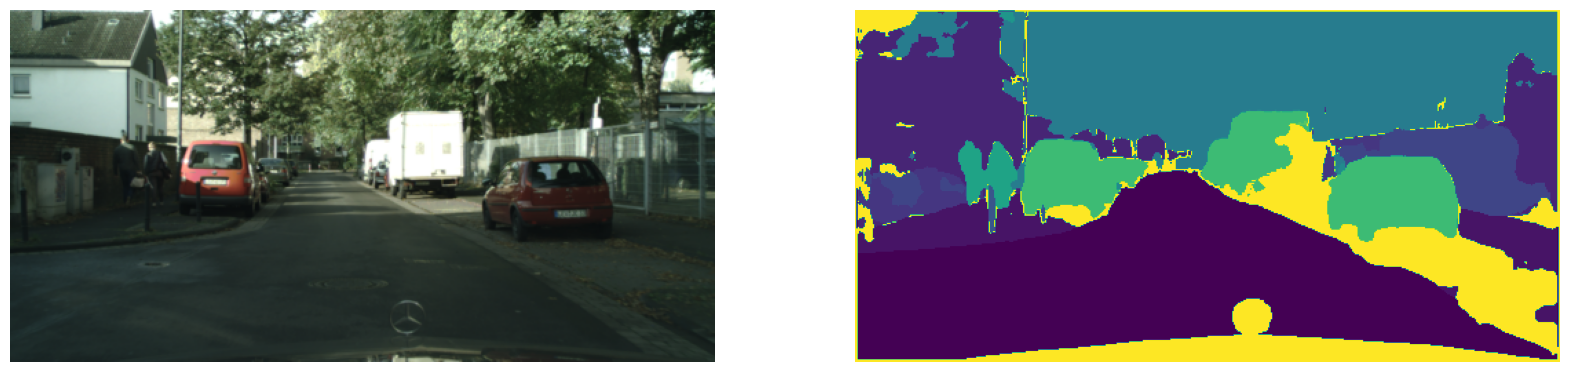

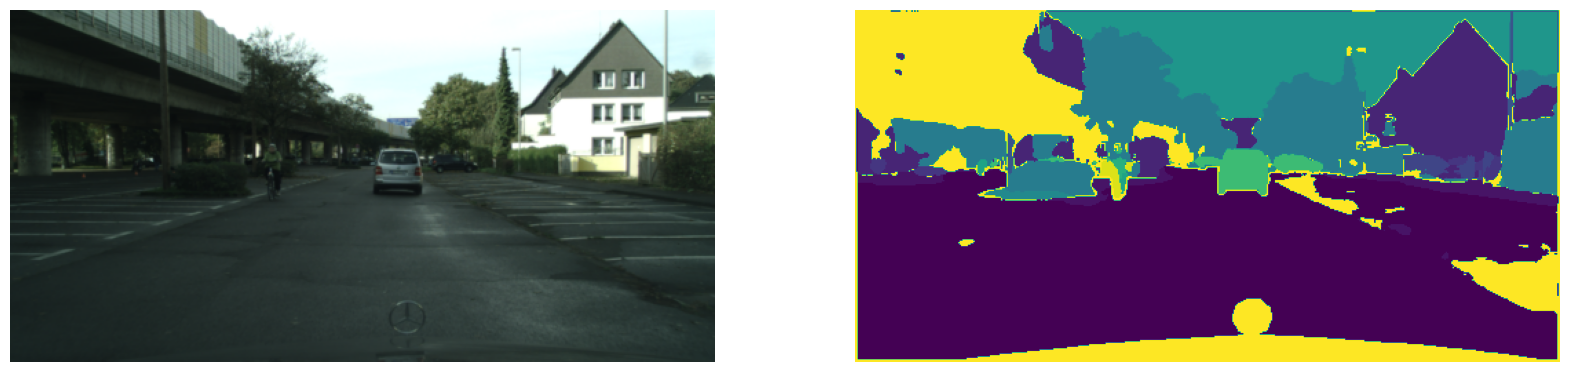

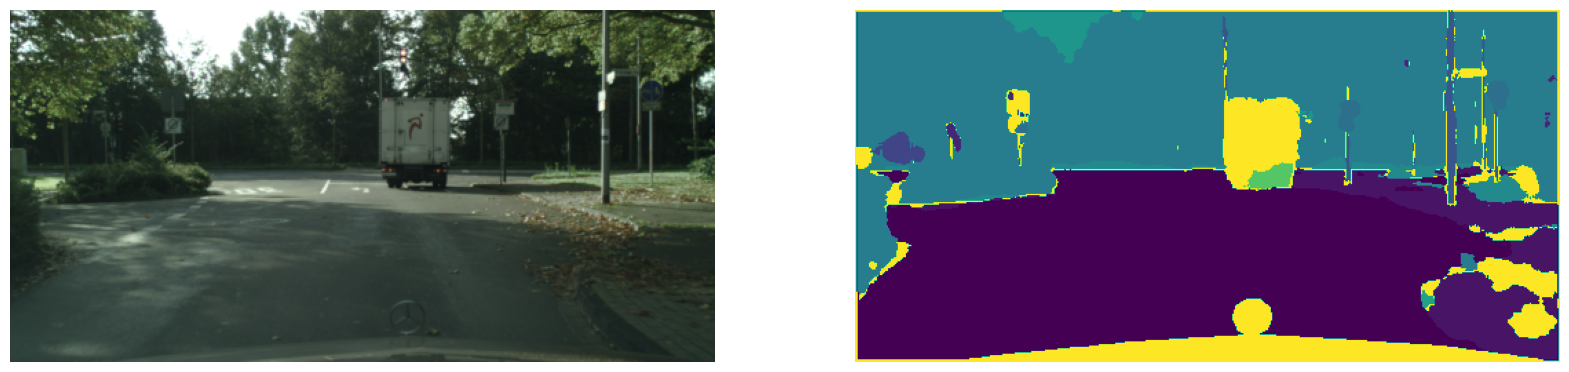

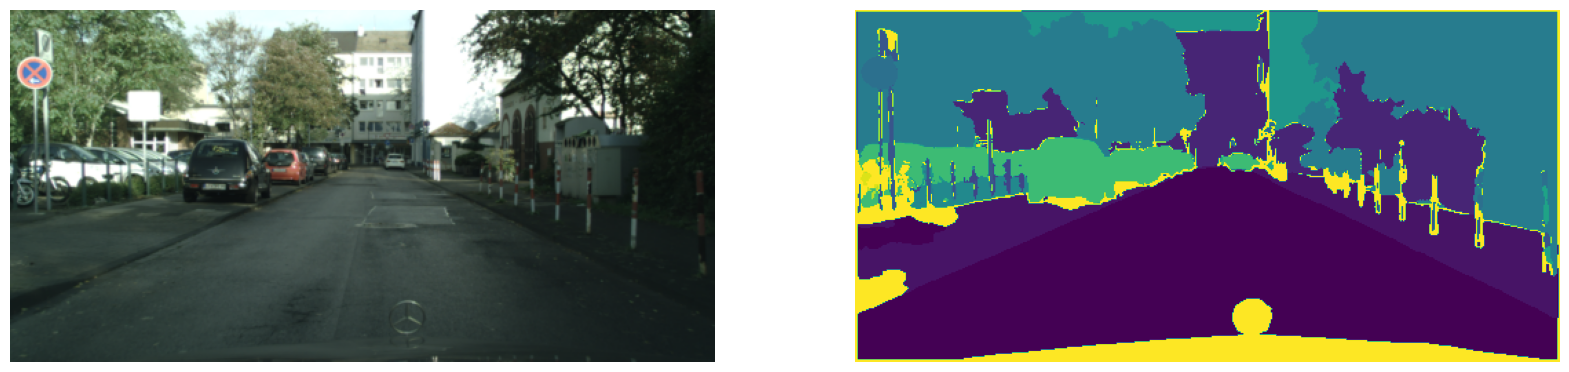

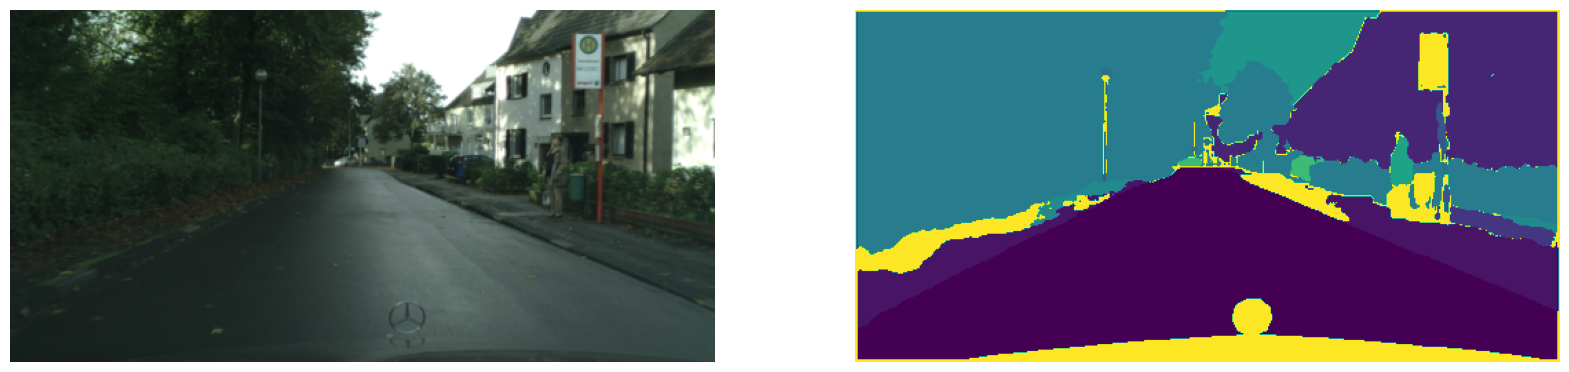

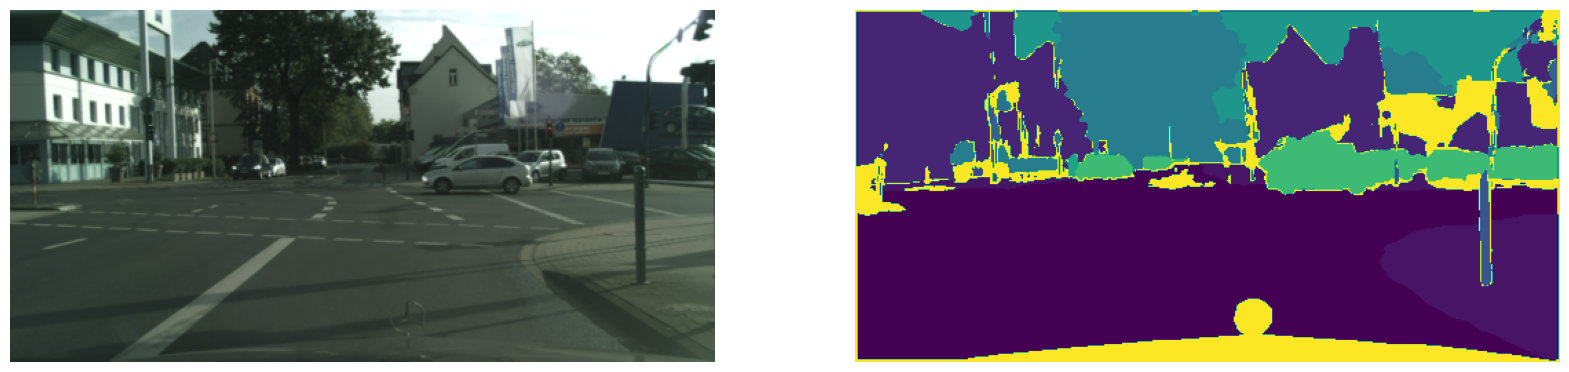

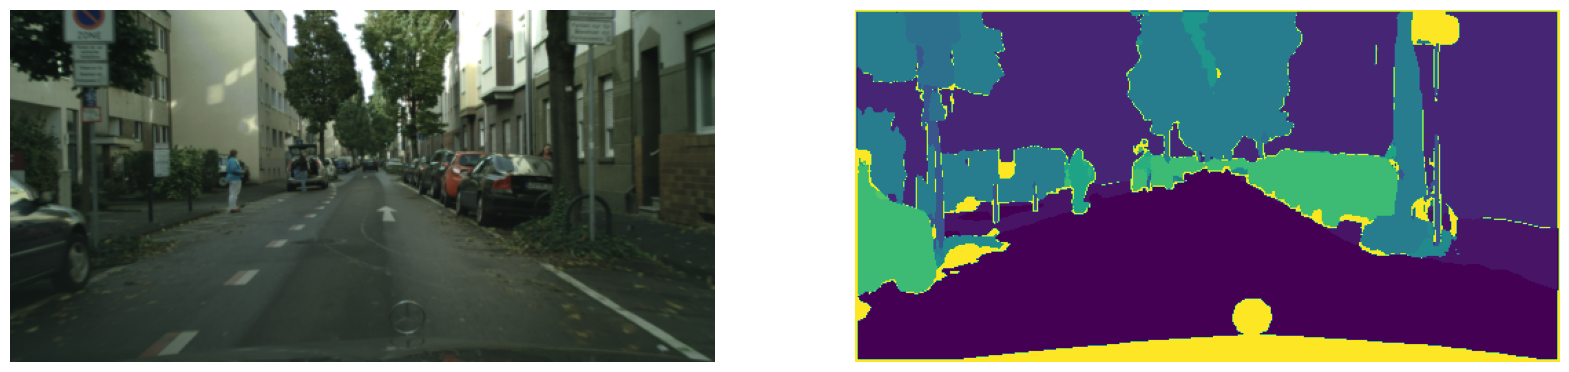

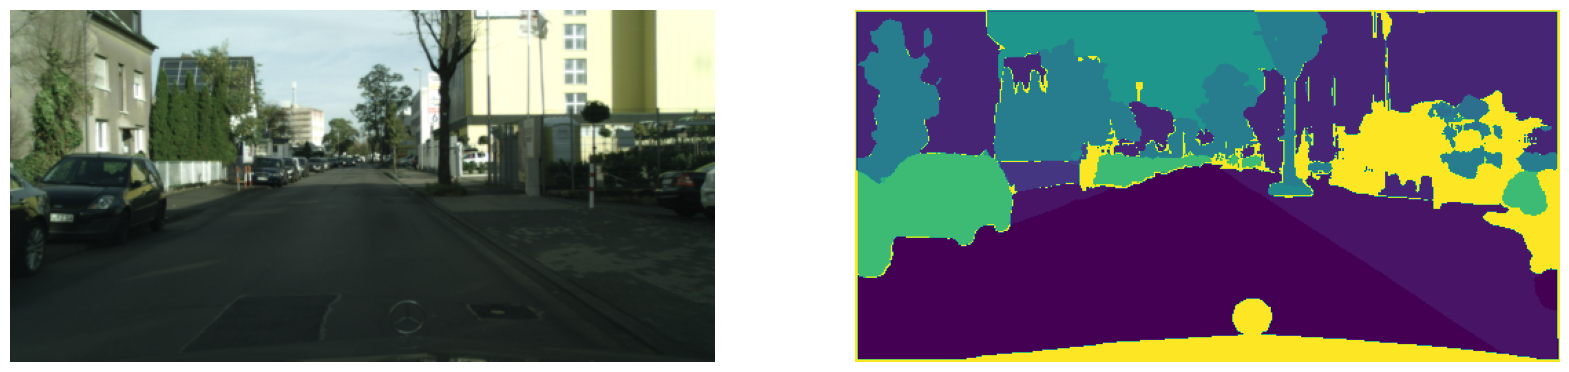

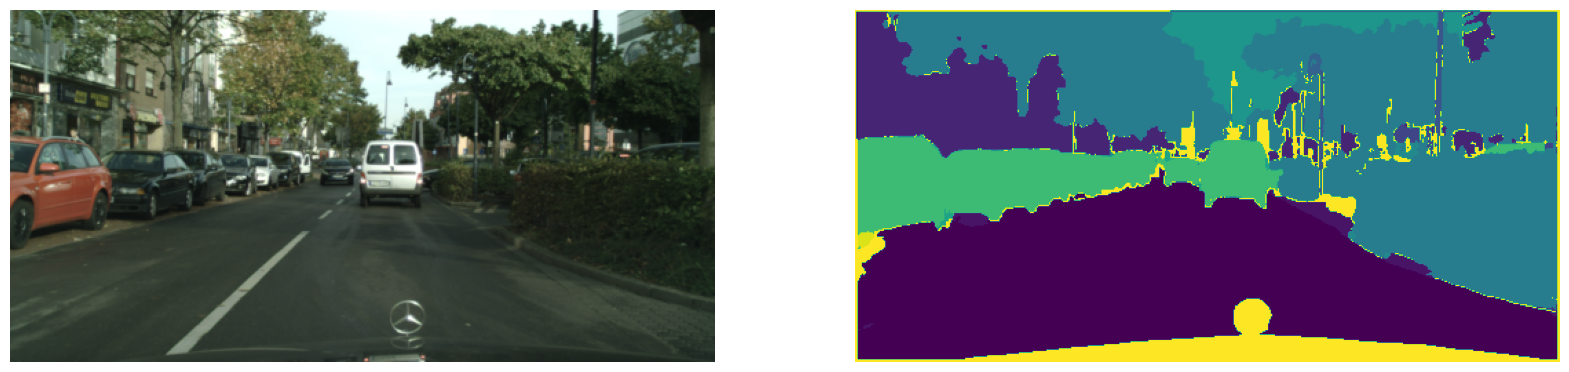

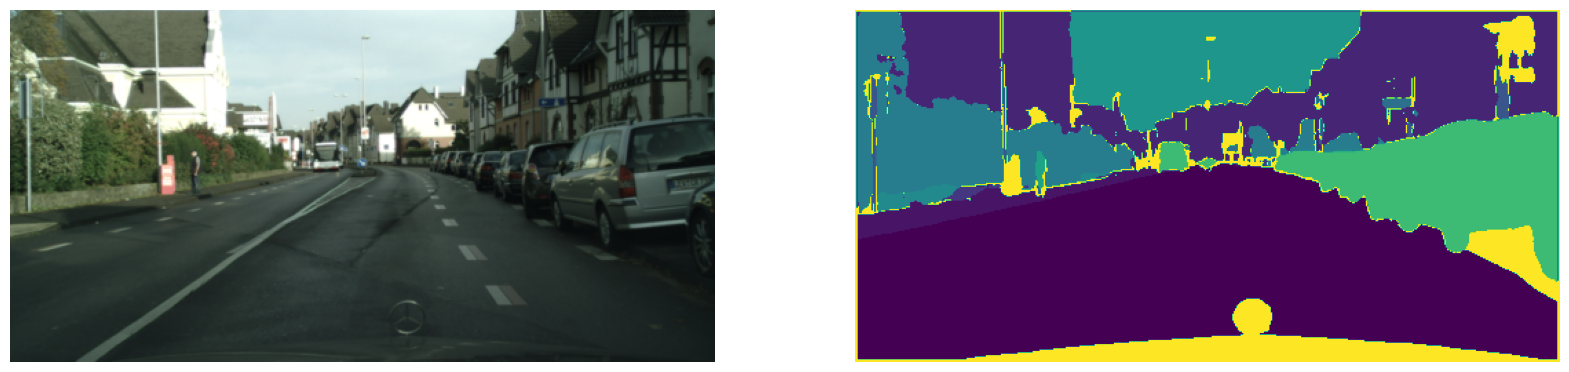

In [24]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 2, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')